In [1]:
# 기본 라이브러리 설치
!pip install torch torchvision tqdm tensorboard matplotlib


In [2]:
#@title 1. 환경 준비
!pip install torch torchvision tqdm tensorboard --quiet

import os
from pathlib import Path

# Colab 기준 작업 디렉토리
BASE_DIR = Path("/content")
DATA_DIR = BASE_DIR / "data"
CHECKPOINTS_DIR = BASE_DIR / "checkpoints"
LOGS_DIR = BASE_DIR / "logs"
SAMPLES_DIR = BASE_DIR / "samples"

for d in [DATA_DIR, CHECKPOINTS_DIR, LOGS_DIR, SAMPLES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ device:", device)


✅ device: cuda


In [3]:
#@title 2. LDM 기본 구성요소 정의 (VAE, UNet, LDM)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class VAEEncoder(nn.Module):
    """
    VAE 인코더 - LDM 1단계 학습: 이미지를 잠재 공간으로 인코딩
    """
    def __init__(self, in_channels=1, latent_dim=64, base_channels=32):
        super().__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            # 28x28 -> 14x14
            nn.Conv2d(in_channels, base_channels, 4, stride=2, padding=1),
            nn.ReLU(),

            # 14x14 -> 7x7
            nn.Conv2d(base_channels, base_channels * 2, 4, stride=2, padding=1),
            nn.ReLU(),

            # 7x7 -> 4x4
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, stride=2, padding=1),
            nn.ReLU(),

            nn.Flatten(),
        )

        self.fc_mu = nn.Linear(base_channels * 4 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(base_channels * 4 * 4 * 4, latent_dim)

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        mu, logvar = self.forward(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar


class VAEDecoder(nn.Module):
    """
    VAE 디코더
    """
    def __init__(self, latent_dim=64, out_channels=1, base_channels=32):
        super().__init__()

        self.latent_dim = latent_dim
        self.base_channels = base_channels
        self.fc = nn.Linear(latent_dim, base_channels * 4 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels * 2, base_channels, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels, out_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(h.size(0), self.base_channels * 4, 4, 4)
        return self.decoder(h)


class LatentUNet(nn.Module):
    """
    잠재 공간용 2D 클래스 조건부 U-Net
    """
    def __init__(self, latent_dim=64, time_dim=128, num_classes=10, class_embed_dim=64, base_channels=64):
        super().__init__()

        self.latent_dim = latent_dim
        self.time_dim = time_dim
        self.num_classes = num_classes
        self.class_embed_dim = class_embed_dim
        self.base_channels = base_channels

        # latent 2D 크기 결정
        if latent_dim == 64:
            self.latent_h, self.latent_w = 8, 8
        elif latent_dim == 80:
            self.latent_h, self.latent_w = 8, 10
        else:
            factors = []
            for i in range(1, int(np.sqrt(latent_dim)) + 1):
                if latent_dim % i == 0:
                    factors.append((i, latent_dim // i))
            if factors:
                self.latent_h, self.latent_w = min(factors, key=lambda x: abs(x[0]-x[1]))
            else:
                sqrt_dim = int(np.sqrt(latent_dim))
                self.latent_h = self.latent_w = sqrt_dim

        print(f"Latent feature map size: {self.latent_h}x{self.latent_w} = {self.latent_h * self.latent_w}")

        self.class_embedding = nn.Embedding(num_classes + 1, class_embed_dim)

        self.time_embedding = self._build_time_embedding(time_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim * 2),
            nn.SiLU(),
            nn.Linear(time_dim * 2, time_dim)
        )

        self.class_mlp = nn.Sequential(
            nn.Linear(class_embed_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )

        self.cond_dim = time_dim * 2

        self.input_conv = nn.Conv2d(1, base_channels, 3, padding=1)

        self.enc1 = self._make_conv_block(base_channels, base_channels * 2, self.cond_dim)
        self.down1 = nn.Conv2d(base_channels * 2, base_channels * 2, 3, stride=2, padding=1)

        self.enc2 = self._make_conv_block(base_channels * 2, base_channels * 4, self.cond_dim)
        self.down2 = nn.Conv2d(base_channels * 4, base_channels * 4, 3, stride=2, padding=1)

        self.middle1 = self._make_conv_block(base_channels * 4, base_channels * 8, self.cond_dim)
        self.attention = self._make_attention_block(base_channels * 8)
        self.middle2 = self._make_conv_block(base_channels * 8, base_channels * 4, self.cond_dim)

        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 4, 3, stride=2, padding=1, output_padding=1)
        self.dec2 = self._make_conv_block(base_channels * 8, base_channels * 2, self.cond_dim)

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 3, stride=2, padding=1, output_padding=1)
        self.dec1 = self._make_conv_block(base_channels * 4, base_channels, self.cond_dim)

        self.output_conv = nn.Sequential(
            nn.Conv2d(base_channels, base_channels // 2, 3, padding=1),
            nn.GroupNorm(8, base_channels // 2),
            nn.SiLU(),
            nn.Conv2d(base_channels // 2, 1, 1)
        )

        print("U-Net 구조:")
        print(f"  입력: 1 -> {base_channels}")
        print(f"  인코더1: {base_channels} -> {base_channels * 2}")
        print(f"  인코더2: {base_channels * 2} -> {base_channels * 4}")
        print(f"  중간: {base_channels * 4} -> {base_channels * 8} -> {base_channels * 4}")
        print(f"  디코더2: {base_channels * 8} -> {base_channels * 2}")
        print(f"  디코더1: {base_channels * 4} -> {base_channels}")
        print(f"  출력: {base_channels} -> 1")

    def _build_time_embedding(self, dim):
        def forward(time):
            device = time.device
            half_dim = dim // 2
            embeddings = np.log(10000) / (half_dim - 1)
            embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
            embeddings = time[:, None] * embeddings[None, :]
            embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
            return embeddings
        return forward

    def _make_conv_block(self, in_channels, out_channels, cond_dim):
        return nn.ModuleDict({
            'conv1': nn.Conv2d(in_channels, out_channels, 3, padding=1),
            'norm1': nn.GroupNorm(min(32, out_channels // 4), out_channels),
            'conv2': nn.Conv2d(out_channels, out_channels, 3, padding=1),
            'norm2': nn.GroupNorm(min(32, out_channels // 4), out_channels),
            'cond_proj': nn.Sequential(
                nn.Linear(cond_dim, out_channels),
                nn.SiLU()
            ),
            'shortcut': nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        })

    def _make_attention_block(self, channels):
        return nn.ModuleDict({
            'norm': nn.GroupNorm(min(32, channels // 4), channels),
            'attention': nn.MultiheadAttention(channels, num_heads=8, batch_first=True)
        })

    def _apply_conv_block(self, x, cond_emb, block_dict):
        h = F.silu(block_dict['norm1'](block_dict['conv1'](x)))
        cond_proj = block_dict['cond_proj'](cond_emb)
        cond_proj = cond_proj[:, :, None, None]
        h = h + cond_proj
        h = F.silu(block_dict['norm2'](block_dict['conv2'](h)))
        return h + block_dict['shortcut'](x)

    def _apply_attention_block(self, x, block_dict):
        B, C, H, W = x.shape
        h = block_dict['norm'](x)
        h = h.view(B, C, H*W).transpose(1, 2)
        h, _ = block_dict['attention'](h, h, h)
        h = h.transpose(1, 2).view(B, C, H, W)
        return x + h

    def forward(self, x, time, class_labels=None):
        batch_size = x.shape[0]

        time_emb = self.time_embedding(time)
        time_emb = self.time_mlp(time_emb)

        if class_labels is None:
            class_labels = torch.full((batch_size,), self.num_classes, device=x.device, dtype=torch.long)
        else:
            if self.training:
                mask = torch.rand(batch_size, device=x.device) < 0.2
                class_labels = torch.where(mask, self.num_classes, class_labels)

        class_emb = self.class_embedding(class_labels)
        class_emb = self.class_mlp(class_emb)

        cond_emb = torch.cat([time_emb, class_emb], dim=1)

        target_size = self.latent_h * self.latent_w
        if x.shape[1] != target_size:
            if x.shape[1] < target_size:
                padding = target_size - x.shape[1]
                x = F.pad(x, (0, padding))
            else:
                x = x[:, :target_size]

        x = x.view(batch_size, 1, self.latent_h, self.latent_w)
        x = self.input_conv(x)

        skip1 = x
        x = self._apply_conv_block(x, cond_emb, self.enc1)
        x = self.down1(x)

        skip2 = x
        x = self._apply_conv_block(x, cond_emb, self.enc2)
        x = self.down2(x)

        x = self._apply_conv_block(x, cond_emb, self.middle1)
        x = self._apply_attention_block(x, self.attention)
        x = self._apply_conv_block(x, cond_emb, self.middle2)

        x = self.up2(x)
        if x.shape[2:] != skip2.shape[2:]:
            x = F.interpolate(x, size=skip2.shape[2:], mode='bilinear', align_corners=False)
        skip2_expanded = torch.cat([skip2, skip2], dim=1)
        x = torch.cat([x, skip2_expanded], dim=1)
        x = self._apply_conv_block(x, cond_emb, self.dec2)

        x = self.up1(x)
        if x.shape[2:] != skip1.shape[2:]:
            x = F.interpolate(x, size=skip1.shape[2:], mode='bilinear', align_corners=False)
        skip1_expanded = torch.cat([skip1, skip1], dim=1)
        x = torch.cat([x, skip1_expanded], dim=1)
        x = self._apply_conv_block(x, cond_emb, self.dec1)

        x = self.output_conv(x)
        x = x.view(batch_size, -1)

        if x.shape[1] > self.latent_dim:
            x = x[:, :self.latent_dim]
        elif x.shape[1] < self.latent_dim:
            padding = self.latent_dim - x.shape[1]
            x = F.pad(x, (0, padding))

        return x


class LDM:
    """
    LDM 메인 클래스
    """
    def __init__(self, vae_encoder, vae_decoder, unet, timesteps=1000,
                 beta_start=1e-4, beta_end=0.02, device='cpu'):
        self.vae_encoder = vae_encoder
        self.vae_decoder = vae_decoder
        self.unet = unet
        self.timesteps = timesteps
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def encode_to_latent(self, x):
        with torch.no_grad():
            z, mu, logvar = self.vae_encoder.encode(x)
            z = z * 0.5
        return z

    def decode_from_latent(self, z):
        with torch.no_grad():
            z = z / 0.5
            x = self.vae_decoder(z)
        return x

    def q_sample(self, z_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(z_start)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        return sqrt_alphas_cumprod_t * z_start + sqrt_one_minus_alphas_cumprod_t * noise

    def p_losses(self, x_start, t, class_labels=None):
        z_start = self.encode_to_latent(x_start)
        noise = torch.randn_like(z_start)
        z_noisy = self.q_sample(z_start, t, noise)
        predicted_noise = self.unet(z_noisy, t, class_labels)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

    @torch.no_grad()
    def p_sample(self, z, t, t_index, class_labels=None):
        betas_t = self.betas[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        sqrt_recip_alphas_t = self.sqrt_recip_alphas[t].view(-1, 1)

        predicted_noise = self.unet(z, t, class_labels)

        model_mean = sqrt_recip_alphas_t * (z - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)

        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = self.posterior_variance[t].view(-1, 1)
            noise = torch.randn_like(z)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def sample(self, batch_size, class_labels=None, return_intermediates=False):
        latent_dim = self.vae_encoder.latent_dim
        z = torch.randn(batch_size, latent_dim, device=self.device) * 0.5
        zs = []
        for i in tqdm(reversed(range(0, self.timesteps)), desc='LDM 샘플링 중', total=self.timesteps):
            t = torch.full((batch_size,), i, device=self.device, dtype=torch.long)
            z = self.p_sample(z, t, i, class_labels)
            if return_intermediates:
                zs.append(z.cpu())
        images = self.decode_from_latent(z)
        if return_intermediates:
            return images, zs
        return images

    @torch.no_grad()
    def ddim_sample(self, batch_size, class_labels=None, eta=0.0, ddim_timesteps=50, return_intermediates=False):
        ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, self.timesteps // ddim_timesteps)))
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])

        latent_dim = self.vae_encoder.latent_dim
        z = torch.randn(batch_size, latent_dim, device=self.device) * 0.5

        zs = []
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='LDM DDIM 샘플링 중', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=self.device, dtype=torch.long)

            predicted_noise = self.unet(z, t, class_labels)

            alpha_cumprod_t = self.alphas_cumprod[ddim_timestep_seq[i]]
            alpha_cumprod_t_prev = self.alphas_cumprod[ddim_timestep_prev_seq[i]]

            pred_z0 = (z - torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_cumprod_t)

            dir_zt = torch.sqrt(1 - alpha_cumprod_t_prev - eta**2 * (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev)) * predicted_noise

            noise = eta * torch.sqrt((1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t)) * torch.sqrt(1 - alpha_cumprod_t / alpha_cumprod_t_prev) * torch.randn_like(z)

            z = torch.sqrt(alpha_cumprod_t_prev) * pred_z0 + dir_zt + noise

            if return_intermediates:
                zs.append(z.cpu())

        images = self.decode_from_latent(z)
        if return_intermediates:
            return images, zs
        return images

    def get_loss(self, x_start, class_labels=None):
        batch_size = x_start.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=self.device).long()
        return self.p_losses(x_start, t, class_labels)


def train_vae(vae_encoder, vae_decoder, dataloader, epochs=20, lr=1e-3, device='cpu', save_dir=None, log_dir=None):
    print("VAE 사전 학습 시작...")

    vae_encoder.train()
    vae_decoder.train()

    optimizer = torch.optim.Adam(list(vae_encoder.parameters()) + list(vae_decoder.parameters()), lr=lr)

    best_loss = float('inf')
    best_encoder_state = None
    best_decoder_state = None

    for epoch in range(epochs):
        total_loss = 0
        recon_loss_total = 0
        kl_loss_total = 0

        progress_bar = tqdm(dataloader, desc=f'VAE 에포크 {epoch+1}/{epochs}')

        for batch_idx, (data, _) in enumerate(progress_bar):
            data = data.to(device)

            z, mu, logvar = vae_encoder.encode(data)
            recon = vae_decoder(z)

            recon_loss = F.mse_loss(recon, data, reduction='sum') / data.size(0)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / data.size(0)

            loss = recon_loss + kl_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()

            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Recon': f'{recon_loss.item():.4f}',
                'KL': f'{kl_loss.item():.4f}',
                'Best': f'{best_loss:.4f}'
            })

        avg_loss = total_loss / len(dataloader)
        avg_recon = recon_loss_total / len(dataloader)
        avg_kl = kl_loss_total / len(dataloader)

        print(f'VAE 에포크 {epoch+1} - 총 손실: {avg_loss:.4f}, 재구성: {avg_recon:.4f}, KL: {avg_kl:.4f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_encoder_state = vae_encoder.state_dict().copy()
            best_decoder_state = vae_decoder.state_dict().copy()

            if save_dir:
                best_vae_path = Path(save_dir) / 'vae_best.pth'
                torch.save({
                    'encoder': best_encoder_state,
                    'decoder': best_decoder_state,
                    'loss': best_loss,
                    'epoch': epoch + 1
                }, str(best_vae_path))
                print(f'🏆 NEW BEST VAE! Loss: {best_loss:.4f} - Saved: {best_vae_path}')

        if (epoch + 1) % 5 == 0:
            visualize_vae_reconstruction(vae_encoder, vae_decoder, dataloader, device)

    if best_encoder_state is not None:
        vae_encoder.load_state_dict(best_encoder_state)
        vae_decoder.load_state_dict(best_decoder_state)
        print(f"✅ VAE 사전 학습 완료! Best 모델로 복원됨 (Loss: {best_loss:.4f})")
    else:
        print("VAE 사전 학습 완료!")

    return vae_encoder, vae_decoder


def visualize_vae_reconstruction(vae_encoder, vae_decoder, dataloader, device):
    vae_encoder.eval()
    vae_decoder.eval()

    with torch.no_grad():
        data, labels = next(iter(dataloader))
        data = data[:8].to(device)
        labels = labels[:8]

        z, mu, logvar = vae_encoder.encode(data)
        recon = vae_decoder(z)

        fig, axes = plt.subplots(2, 8, figsize=(16, 4))

        for i in range(8):
            axes[0, i].imshow(data[i, 0].cpu().numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title(f'Original: {labels[i].item()}')

            axes[1, i].imshow(recon[i, 0].cpu().numpy(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title(f'Recon: {labels[i].item()}')

        plt.suptitle('VAE Reconstruction Results')
        plt.tight_layout()
        plt.show()

    vae_encoder.train()
    vae_decoder.train()



In [4]:
#@title 3. LDM 학습/평가 유틸 전체

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from torch.utils.tensorboard import SummaryWriter

# 위 셀에서 정의한 LDM, VAEEncoder, VAEDecoder, LatentUNet, train_vae 를 그대로 사용

def create_dataloader(batch_size=128, num_workers=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = datasets.MNIST(
        root=str(DATA_DIR),
        train=True,
        download=True,
        transform=transform
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    return dataloader

def save_vae_reconstruction_samples(vae_encoder, vae_decoder, dataloader, device, save_path):
    vae_encoder.eval()
    vae_decoder.eval()

    with torch.no_grad():
        data, labels = next(iter(dataloader))
        data = data[:8].to(device)
        labels = labels[:8]

        z, mu, logvar = vae_encoder.encode(data)
        recon = vae_decoder(z)

        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            axes[0, i].imshow(data[i, 0].cpu().numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title(f'Original: {labels[i].item()}')

            axes[1, i].imshow(recon[i, 0].cpu().numpy(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title(f'Recon: {labels[i].item()}')

        plt.suptitle('VAE Reconstruction Results')
        plt.tight_layout()
        plt.savefig(str(save_path), dpi=150, bbox_inches='tight')
        plt.close()

        print(f"VAE reconstruction samples saved: {save_path}")

    vae_encoder.train()
    vae_decoder.train()

def train_ldm(
    vae_encoder,
    vae_decoder,
    unet,
    ldm,
    dataloader,
    epochs=20,       # Colab이라 기본 20으로 줄여둠 (원래 코드 50~100도 가능)
    lr=2e-4,
    device='cpu',
    save_dir=CHECKPOINTS_DIR,
    log_dir=LOGS_DIR,
    save_every=5,
    sample_every=5,
    vae_pretrain_epochs=5,  # Colab이라 기본 5
    load_vae_checkpoint=None
):
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(SAMPLES_DIR, exist_ok=True)

    print("=== 1단계: VAE 준비 ===")
    if load_vae_checkpoint and os.path.exists(load_vae_checkpoint):
        print(f"✅ VAE 체크포인트 로드: {load_vae_checkpoint}")
        checkpoint = torch.load(load_vae_checkpoint, map_location=device)
        vae_encoder.load_state_dict(checkpoint['encoder'])
        vae_decoder.load_state_dict(checkpoint['decoder'])
        best_vae_encoder = vae_encoder
        best_vae_decoder = vae_decoder

        vae_recon_path = SAMPLES_DIR / 'vae_reconstruction_loaded.png'
        save_vae_reconstruction_samples(vae_encoder, vae_decoder, dataloader, device, vae_recon_path)
    else:
        print("VAE 사전 학습을 시작합니다.")
        best_vae_encoder, best_vae_decoder = train_vae(
            vae_encoder, vae_decoder, dataloader,
            epochs=vae_pretrain_epochs, lr=lr, device=device,
            save_dir=save_dir, log_dir=log_dir
        )

    print("\n=== 2단계: LDM Diffusion 학습 ===")

    best_vae_encoder.eval()
    best_vae_decoder.eval()
    for p in best_vae_encoder.parameters():
        p.requires_grad = False
    for p in best_vae_decoder.parameters():
        p.requires_grad = False

    ldm.vae_encoder = best_vae_encoder
    ldm.vae_decoder = best_vae_decoder

    optimizer = optim.AdamW(unet.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)

    writer = SummaryWriter(str(log_dir / 'ldm'))

    unet.train()
    best_loss = float('inf')
    global_step = 0

    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f'LDM Epoch {epoch+1}/{epochs}')

        for batch_idx, (data, labels) in enumerate(progress_bar):
            data = data.to(device)
            labels = labels.to(device)

            loss = ldm.get_loss(data, labels)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()
            global_step += 1

            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg': f'{epoch_loss/(batch_idx+1):.4f}',
                'Best': f'{best_loss:.4f}',
                'LR': f'{scheduler.get_last_lr()[0]:.6f}'
            })

            if global_step % 100 == 0:
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('LR', scheduler.get_last_lr()[0], global_step)

        avg_loss = epoch_loss / len(dataloader)
        scheduler.step()

        print(f'[LDM] Epoch {epoch+1} done. avg_loss={avg_loss:.4f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_path = save_dir / 'ldm_best.pth'
            torch.save({
                'epoch': epoch+1,
                'unet_state_dict': unet.state_dict(),
                'vae_encoder_state_dict': best_vae_encoder.state_dict(),
                'vae_decoder_state_dict': best_vae_decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_loss,
            }, str(best_path))
            print(f'🏆 NEW BEST MODEL! {best_path}')

        if (epoch + 1) % sample_every == 0:
            print("샘플 생성 중...")
            unet.eval()
            with torch.no_grad():
                vae_recon_path = SAMPLES_DIR / f'vae_reconstruction_epoch_{epoch+1:03d}.png'
                save_vae_reconstruction_samples(best_vae_encoder, best_vae_decoder, dataloader, device, vae_recon_path)

                class_labels = torch.tensor(list(range(10)) + list(range(6)), device=device)
                samples = ldm.sample(len(class_labels), class_labels=class_labels)

                fig, axes = plt.subplots(4, 4, figsize=(10, 10))
                for i in range(len(class_labels)):
                    r, c = divmod(i, 4)
                    axes[r, c].imshow(samples[i, 0].cpu().numpy(), cmap='gray')
                    axes[r, c].axis('off')
                    axes[r, c].set_title(f'{class_labels[i].item()}')
                plt.tight_layout()
                sample_path = SAMPLES_DIR / f'ldm_epoch_{epoch+1:03d}.png'
                plt.savefig(str(sample_path), dpi=150, bbox_inches='tight')
                plt.close()
                print(f"LDM samples saved: {sample_path}")
            unet.train()

        if (epoch + 1) % save_every == 0:
            ckpt_path = save_dir / f'ldm_epoch_{epoch+1:03d}.pth'
            torch.save({
                'epoch': epoch+1,
                'unet_state_dict': unet.state_dict(),
                'vae_encoder_state_dict': best_vae_encoder.state_dict(),
                'vae_decoder_state_dict': best_vae_decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_loss,
                'best_loss': best_loss
            }, str(ckpt_path))
            print(f"LDM checkpoint saved: {ckpt_path}")

    final_path = save_dir / 'ldm_final.pth'
    torch.save({
        'unet_state_dict': unet.state_dict(),
        'vae_encoder_state_dict': best_vae_encoder.state_dict(),
        'vae_decoder_state_dict': best_vae_decoder.state_dict(),
        'best_loss': best_loss
    }, str(final_path))
    writer.close()
    print("✅ LDM training completed.")
    return best_vae_encoder, best_vae_decoder, unet, ldm

def evaluate_model(unet, ldm, dataloader, device):
    unet.eval()
    print("=== LDM 평가 ===")
    save_vae_reconstruction_samples(ldm.vae_encoder, ldm.vae_decoder, dataloader, device, SAMPLES_DIR / "vae_recon_final.png")
    with torch.no_grad():
        # 🔹 여기서 이제 DDIM만 사용
        samples = ldm.ddim_sample(8, ddim_timesteps=50)
        fig, axes = plt.subplots(1, 8, figsize=(16, 2))
        for i in range(8):
            axes[i].imshow(samples[i, 0].cpu().numpy(), cmap='gray')
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 607kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


train batches: 469
Latent feature map size: 8x10 = 80
U-Net 구조:
  입력: 1 -> 64
  인코더1: 64 -> 128
  인코더2: 128 -> 256
  중간: 256 -> 512 -> 256
  디코더2: 512 -> 128
  디코더1: 256 -> 64
  출력: 64 -> 1


LDM 샘플링 중: 100%|██████████| 300/300 [00:04<00:00, 65.70it/s] 


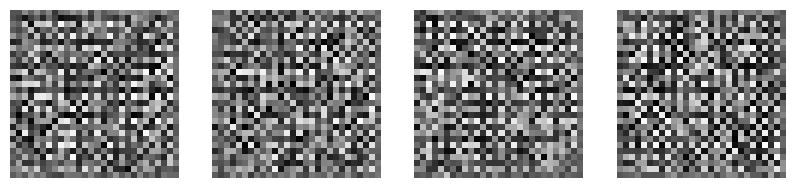

=== 1단계: VAE 준비 ===
VAE 사전 학습을 시작합니다.
VAE 사전 학습 시작...


VAE 에포크 1/10: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s, Loss=120.1769, Recon=87.3589, KL=32.8180, Best=inf]


VAE 에포크 1 - 총 손실: 187.3038, 재구성: 165.7870, KL: 21.5168
🏆 NEW BEST VAE! Loss: 187.3038 - Saved: /content/checkpoints/vae_best.pth


VAE 에포크 2/10: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s, Loss=87.0377, Recon=53.8947, KL=33.1430, Best=187.3038]


VAE 에포크 2 - 총 손실: 101.5782, 재구성: 67.7103, KL: 33.8679
🏆 NEW BEST VAE! Loss: 101.5782 - Saved: /content/checkpoints/vae_best.pth


VAE 에포크 3/10: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s, Loss=79.0041, Recon=45.7418, KL=33.2623, Best=101.5782]


VAE 에포크 3 - 총 손실: 84.0094, 재구성: 50.2286, KL: 33.7808
🏆 NEW BEST VAE! Loss: 84.0094 - Saved: /content/checkpoints/vae_best.pth


VAE 에포크 4/10: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s, Loss=74.8736, Recon=41.5262, KL=33.3474, Best=84.0094]


VAE 에포크 4 - 총 손실: 76.1751, 재구성: 43.2683, KL: 32.9067
🏆 NEW BEST VAE! Loss: 76.1751 - Saved: /content/checkpoints/vae_best.pth


VAE 에포크 5/10: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s, Loss=70.9589, Recon=38.9486, KL=32.0103, Best=76.1751]

VAE 에포크 5 - 총 손실: 72.1630, 재구성: 39.6486, KL: 32.5143
🏆 NEW BEST VAE! Loss: 72.1630 - Saved: /content/checkpoints/vae_best.pth


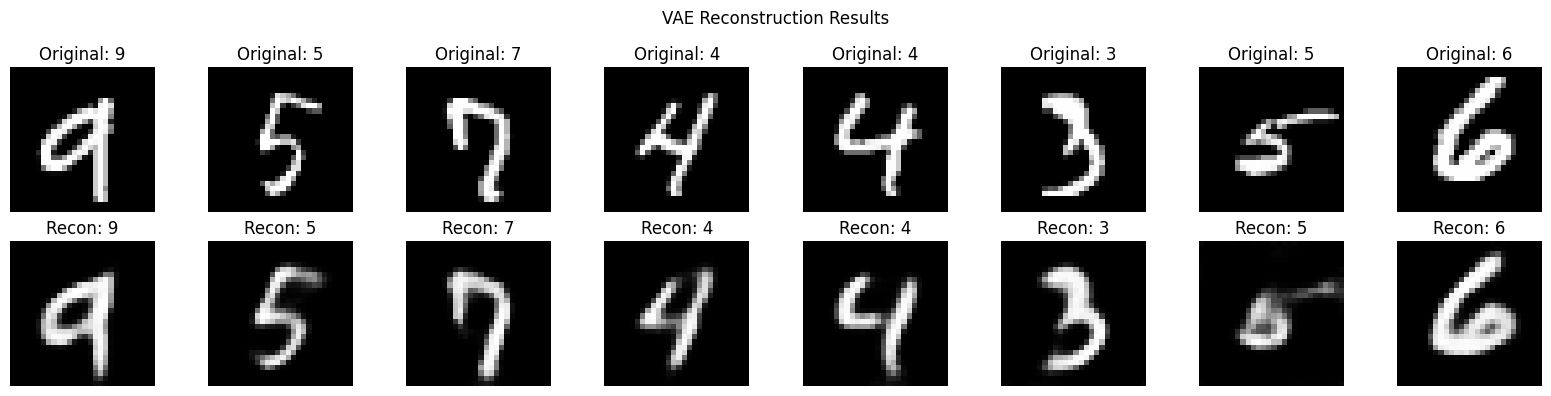

VAE 에포크 6/10: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s, Loss=68.0127, Recon=35.8560, KL=32.1567, Best=72.1630]


VAE 에포크 6 - 총 손실: 69.7036, 재구성: 37.4221, KL: 32.2814
🏆 NEW BEST VAE! Loss: 69.7036 - Saved: /content/checkpoints/vae_best.pth


VAE 에포크 7/10: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s, Loss=69.9387, Recon=36.3023, KL=33.6365, Best=69.7036]


VAE 에포크 7 - 총 손실: 68.0649, 재구성: 35.8754, KL: 32.1894
🏆 NEW BEST VAE! Loss: 68.0649 - Saved: /content/checkpoints/vae_best.pth


VAE 에포크 8/10: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s, Loss=64.5903, Recon=32.0359, KL=32.5544, Best=68.0649]


VAE 에포크 8 - 총 손실: 66.7603, 재구성: 34.7433, KL: 32.0169
🏆 NEW BEST VAE! Loss: 66.7603 - Saved: /content/checkpoints/vae_best.pth


VAE 에포크 9/10: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s, Loss=63.1553, Recon=31.9795, KL=31.1758, Best=66.7603]


VAE 에포크 9 - 총 손실: 65.8056, 재구성: 33.8643, KL: 31.9413
🏆 NEW BEST VAE! Loss: 65.8056 - Saved: /content/checkpoints/vae_best.pth


VAE 에포크 10/10: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s, Loss=65.5281, Recon=32.9128, KL=32.6153, Best=65.8056]

VAE 에포크 10 - 총 손실: 65.1168, 재구성: 33.2132, KL: 31.9036
🏆 NEW BEST VAE! Loss: 65.1168 - Saved: /content/checkpoints/vae_best.pth


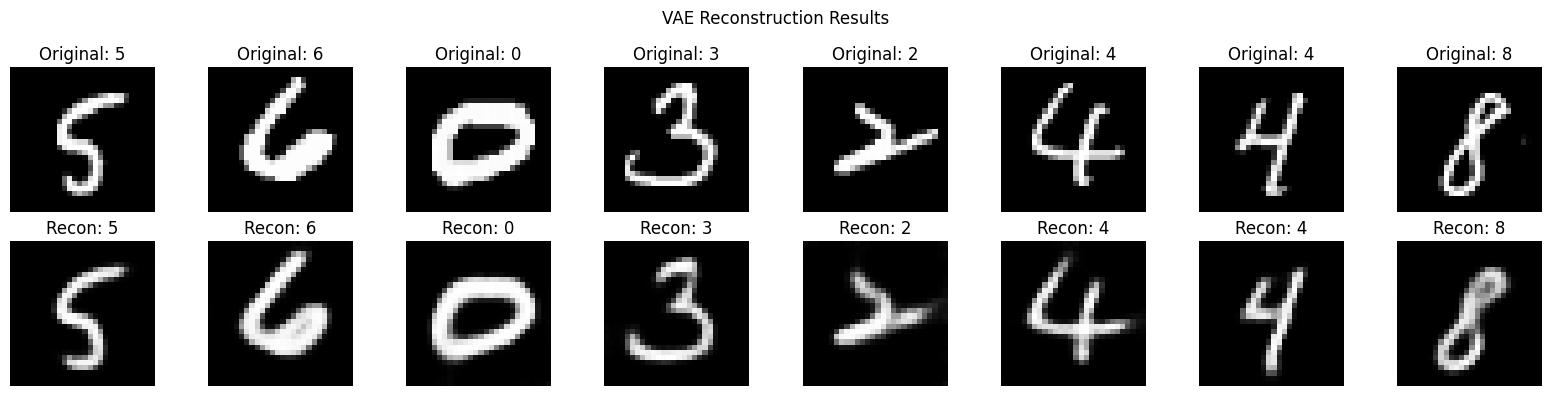

✅ VAE 사전 학습 완료! Best 모델로 복원됨 (Loss: 65.1168)

=== 2단계: LDM Diffusion 학습 ===


LDM Epoch 1/25: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s, Loss=0.2455, Avg=0.3239, Best=inf, LR=0.000200]


[LDM] Epoch 1 done. avg_loss=0.3239
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth


LDM Epoch 2/25: 100%|██████████| 469/469 [00:31<00:00, 15.01it/s, Loss=0.3160, Avg=0.3089, Best=0.3239, LR=0.000199]


[LDM] Epoch 2 done. avg_loss=0.3089
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth


LDM Epoch 3/25: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s, Loss=0.2550, Avg=0.3091, Best=0.3089, LR=0.000197]


[LDM] Epoch 3 done. avg_loss=0.3091


LDM Epoch 4/25: 100%|██████████| 469/469 [00:29<00:00, 15.85it/s, Loss=0.3572, Avg=0.3066, Best=0.3089, LR=0.000194]


[LDM] Epoch 4 done. avg_loss=0.3066
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth


LDM Epoch 5/25: 100%|██████████| 469/469 [00:28<00:00, 16.24it/s, Loss=0.2414, Avg=0.3056, Best=0.3066, LR=0.000189]


[LDM] Epoch 5 done. avg_loss=0.3056
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth
샘플 생성 중...
VAE reconstruction samples saved: /content/samples/vae_reconstruction_epoch_005.png


LDM 샘플링 중: 100%|██████████| 300/300 [00:01<00:00, 214.75it/s]


LDM samples saved: /content/samples/ldm_epoch_005.png
LDM checkpoint saved: /content/checkpoints/ldm_epoch_005.pth


LDM Epoch 6/25: 100%|██████████| 469/469 [00:30<00:00, 15.44it/s, Loss=0.3123, Avg=0.3025, Best=0.3056, LR=0.000183]


[LDM] Epoch 6 done. avg_loss=0.3025
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth


LDM Epoch 7/25: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s, Loss=0.3600, Avg=0.3003, Best=0.3025, LR=0.000176]


[LDM] Epoch 7 done. avg_loss=0.3003
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth


LDM Epoch 8/25: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s, Loss=0.2670, Avg=0.3028, Best=0.3003, LR=0.000167]


[LDM] Epoch 8 done. avg_loss=0.3028


LDM Epoch 9/25: 100%|██████████| 469/469 [00:28<00:00, 16.44it/s, Loss=0.2657, Avg=0.3000, Best=0.3003, LR=0.000158]


[LDM] Epoch 9 done. avg_loss=0.3000
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth


LDM Epoch 10/25: 100%|██████████| 469/469 [00:28<00:00, 16.23it/s, Loss=0.3163, Avg=0.3022, Best=0.3000, LR=0.000148]

[LDM] Epoch 10 done. avg_loss=0.3022
샘플 생성 중...


VAE reconstruction samples saved: /content/samples/vae_reconstruction_epoch_010.png


LDM 샘플링 중: 100%|██████████| 300/300 [00:01<00:00, 223.07it/s]


LDM samples saved: /content/samples/ldm_epoch_010.png
LDM checkpoint saved: /content/checkpoints/ldm_epoch_010.pth


LDM Epoch 11/25: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s, Loss=0.2909, Avg=0.2993, Best=0.3000, LR=0.000138]


[LDM] Epoch 11 done. avg_loss=0.2993
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth


LDM Epoch 12/25: 100%|██████████| 469/469 [00:28<00:00, 16.31it/s, Loss=0.3313, Avg=0.3009, Best=0.2993, LR=0.000127]


[LDM] Epoch 12 done. avg_loss=0.3009


LDM Epoch 13/25: 100%|██████████| 469/469 [00:29<00:00, 16.10it/s, Loss=0.3607, Avg=0.2988, Best=0.2993, LR=0.000116]


[LDM] Epoch 13 done. avg_loss=0.2988
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth


LDM Epoch 14/25: 100%|██████████| 469/469 [00:28<00:00, 16.30it/s, Loss=0.2775, Avg=0.3001, Best=0.2988, LR=0.000104]


[LDM] Epoch 14 done. avg_loss=0.3001


LDM Epoch 15/25: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s, Loss=0.2704, Avg=0.2986, Best=0.2988, LR=0.000093]


[LDM] Epoch 15 done. avg_loss=0.2986
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth
샘플 생성 중...
VAE reconstruction samples saved: /content/samples/vae_reconstruction_epoch_015.png


LDM 샘플링 중: 100%|██████████| 300/300 [00:01<00:00, 219.34it/s]


LDM samples saved: /content/samples/ldm_epoch_015.png
LDM checkpoint saved: /content/checkpoints/ldm_epoch_015.pth


LDM Epoch 16/25: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s, Loss=0.3407, Avg=0.2977, Best=0.2986, LR=0.000082]


[LDM] Epoch 16 done. avg_loss=0.2977
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth


LDM Epoch 17/25: 100%|██████████| 469/469 [00:28<00:00, 16.27it/s, Loss=0.3571, Avg=0.2986, Best=0.2977, LR=0.000072]


[LDM] Epoch 17 done. avg_loss=0.2986


LDM Epoch 18/25: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s, Loss=0.3376, Avg=0.2977, Best=0.2977, LR=0.000062]


[LDM] Epoch 18 done. avg_loss=0.2977


LDM Epoch 19/25: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s, Loss=0.2631, Avg=0.2986, Best=0.2977, LR=0.000053]


[LDM] Epoch 19 done. avg_loss=0.2986


LDM Epoch 20/25: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s, Loss=0.2672, Avg=0.2945, Best=0.2977, LR=0.000044]


[LDM] Epoch 20 done. avg_loss=0.2945
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth
샘플 생성 중...
VAE reconstruction samples saved: /content/samples/vae_reconstruction_epoch_020.png


LDM 샘플링 중: 100%|██████████| 300/300 [00:01<00:00, 220.69it/s]


LDM samples saved: /content/samples/ldm_epoch_020.png
LDM checkpoint saved: /content/checkpoints/ldm_epoch_020.pth


LDM Epoch 21/25: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s, Loss=0.3132, Avg=0.2955, Best=0.2945, LR=0.000037]


[LDM] Epoch 21 done. avg_loss=0.2955


LDM Epoch 22/25: 100%|██████████| 469/469 [00:28<00:00, 16.25it/s, Loss=0.3060, Avg=0.2968, Best=0.2945, LR=0.000031]


[LDM] Epoch 22 done. avg_loss=0.2968


LDM Epoch 23/25: 100%|██████████| 469/469 [00:30<00:00, 15.33it/s, Loss=0.2652, Avg=0.2940, Best=0.2945, LR=0.000026]


[LDM] Epoch 23 done. avg_loss=0.2940
🏆 NEW BEST MODEL! /content/checkpoints/ldm_best.pth


LDM Epoch 24/25: 100%|██████████| 469/469 [00:29<00:00, 16.08it/s, Loss=0.2846, Avg=0.2942, Best=0.2940, LR=0.000023]


[LDM] Epoch 24 done. avg_loss=0.2942


LDM Epoch 25/25: 100%|██████████| 469/469 [00:29<00:00, 15.95it/s, Loss=0.3143, Avg=0.2953, Best=0.2940, LR=0.000021]

[LDM] Epoch 25 done. avg_loss=0.2953
샘플 생성 중...


VAE reconstruction samples saved: /content/samples/vae_reconstruction_epoch_025.png


LDM 샘플링 중: 100%|██████████| 300/300 [00:01<00:00, 206.69it/s]


LDM samples saved: /content/samples/ldm_epoch_025.png
LDM checkpoint saved: /content/checkpoints/ldm_epoch_025.pth
✅ LDM training completed.
=== LDM 평가 ===
VAE reconstruction samples saved: /content/samples/vae_recon_final.png


LDM DDIM 샘플링 중: 100%|██████████| 50/50 [00:00<00:00, 129.89it/s]


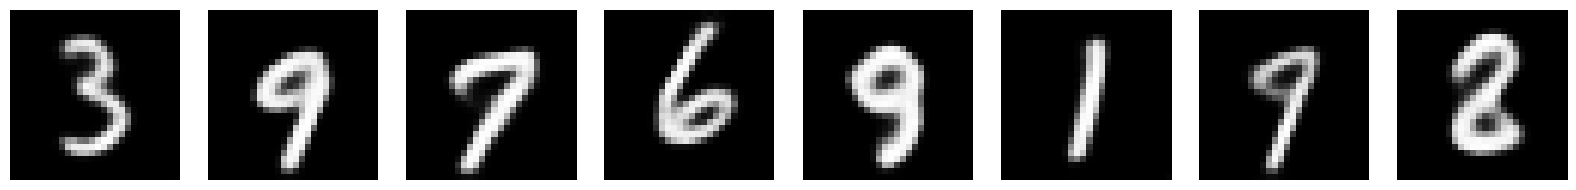

✅ MNIST base LDM ready


In [5]:
#@title 4. MNIST로 베이스 LDM 학습

mnist_trainloader = create_dataloader(batch_size=128)
print("train batches:", len(mnist_trainloader))

latent_dim = 80
vae_encoder = VAEEncoder(latent_dim=latent_dim).to(device)
vae_decoder = VAEDecoder(latent_dim=latent_dim).to(device)
unet = LatentUNet(latent_dim=latent_dim).to(device)
ldm = LDM(vae_encoder, vae_decoder, unet, timesteps=300, device=device)

# 학습 전 샘플
with torch.no_grad():
    pre = ldm.sample(4)
    fig,ax = plt.subplots(1,4, figsize=(10,3))
    for i in range(4):
        ax[i].imshow(pre[i,0].cpu().numpy(), cmap='gray')
        ax[i].axis('off')
    plt.show()

# 학습
vae_encoder, vae_decoder, unet, ldm = train_ldm(
    vae_encoder, vae_decoder, unet, ldm,
    mnist_trainloader,
    epochs=10,             # Colab 테스트라 짧게
    lr=2e-4,
    device=device,
    vae_pretrain_epochs=10
)

# 평가
evaluate_model(unet, ldm, mnist_trainloader, device)

print("✅ MNIST base LDM ready")


In [10]:
#@title 5. U-Net에 붙일 LoRA 정의 (Conv + Attention 대응)

import copy
import torch.nn.functional as F
import torch.nn as nn

# ------------------------
# 1. LoRAConv2d 정의
# ------------------------
class LoRAConv2d(nn.Module):
    """
    Conv2d + LoRA (1x1 down/up)
    출력 = Conv(x) + scale * up(down(x))
    """
    def __init__(self, conv: nn.Conv2d, rank=4, alpha=1.0):
        super().__init__()
        self.conv = conv
        for p in self.conv.parameters():
            p.requires_grad = False

        in_ch = conv.in_channels
        out_ch = conv.out_channels
        self.lora_down = nn.Conv2d(in_ch, rank, kernel_size=1, bias=False)
        self.lora_up   = nn.Conv2d(rank, out_ch, kernel_size=1, bias=False)
        nn.init.zeros_(self.lora_down.weight)
        nn.init.zeros_(self.lora_up.weight)
        self.scale = alpha / rank

    def forward(self, x):
        return self.conv(x) + self.scale * self.lora_up(self.lora_down(x))


# ------------------------
# 2. LoRAMultiheadAttention 정의
# ------------------------
class LoRAMultiheadAttention(nn.Module):
    """
    nn.MultiheadAttention을 감싸서 Q,V projection에 LoRA 적용
    (PyTorch의 MHA는 in_proj_weight를 사용하므로 Q/V 분리 없이 LoRA를 추가)
    """
    def __init__(self, attn: nn.MultiheadAttention, rank=4, alpha=1.0):
        super().__init__()
        self.attn = attn
        for p in self.attn.parameters():
            p.requires_grad = False

        embed_dim = attn.embed_dim
        self.rank = rank
        self.scale = alpha / rank

        # Q, V 각각에 대해 LoRA 다운/업
        self.q_down = nn.Linear(embed_dim, rank, bias=False)
        self.q_up   = nn.Linear(rank, embed_dim, bias=False)
        self.v_down = nn.Linear(embed_dim, rank, bias=False)
        self.v_up   = nn.Linear(rank, embed_dim, bias=False)

        nn.init.kaiming_uniform_(self.q_down.weight, a=5 ** 0.5)
        nn.init.zeros_(self.q_up.weight)
        nn.init.kaiming_uniform_(self.v_down.weight, a=5 ** 0.5)
        nn.init.zeros_(self.v_up.weight)

    def forward(self, query, key, value, **kwargs):
        # Q,V에 LoRA 추가 (입력은 동일)
        q_lora = self.q_up(self.q_down(query)) * self.scale
        v_lora = self.v_up(self.v_down(value)) * self.scale

        query = query + q_lora
        value = value + v_lora

        return self.attn(query, key, value, **kwargs)


# ------------------------
# 3. LoRA 주입 함수
# ------------------------
def add_lora_to_unet(unet, rank=4, alpha=1.0):
    """
    LatentUNet의 Conv + Attention 레이어에 LoRA 주입
    """
    def maybe_wrap_conv(m):
        if isinstance(m, LoRAConv2d): return m
        if isinstance(m, nn.Conv2d):  return LoRAConv2d(m, rank, alpha)
        return m

    def maybe_wrap_attn(m):
        if isinstance(m, LoRAMultiheadAttention): return m
        if isinstance(m, nn.MultiheadAttention):  return LoRAMultiheadAttention(m, rank, alpha)
        return m

    # 입력 conv
    unet.input_conv = maybe_wrap_conv(unet.input_conv)

    # 인코더/디코더 conv 블록들
    for name in ['enc1', 'enc2', 'middle1', 'middle2', 'dec2', 'dec1']:
        block = getattr(unet, name)
        block['conv1'] = maybe_wrap_conv(block['conv1'])
        block['conv2'] = maybe_wrap_conv(block['conv2'])

        # shortcut freeze
        if not isinstance(block['shortcut'], nn.Identity):
            for p in block['shortcut'].parameters():
                p.requires_grad = False

    # 중간 Attention 블록 감싸기
    if hasattr(unet, 'attention'):
        attn_block = unet.attention
        if isinstance(attn_block, nn.ModuleDict) and 'attention' in attn_block:
            attn_block['attention'] = maybe_wrap_attn(attn_block['attention'])

    # 다운/업/출력 conv freeze
    for name in ['down1', 'down2', 'up1', 'up2', 'output_conv']:
        m = getattr(unet, name)
        for p in m.parameters():
            p.requires_grad = False

    return unet



🧮 SyntheticDigits samples: 10000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


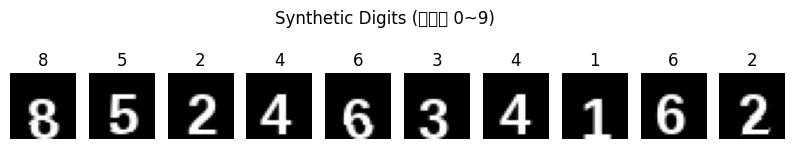

🔧 Injecting LoRA into U-Net (Conv + Attention)...
📊 LDM 전체 파라미터: 10.78M
📦 LoRA 학습 파라미터: 0.51M
🔹 전체 대비 LoRA 비율: 4.698%


LoRA on SyntheticDigits 1/20: 100%|██████████| 79/79 [00:04<00:00, 17.30it/s, avg=0.2753, loss=0.1949]


[LoRA-SyntheticDigits] epoch 1 avg_loss=0.2753


LoRA on SyntheticDigits 2/20: 100%|██████████| 79/79 [00:05<00:00, 15.73it/s, avg=0.2736, loss=0.3383]


[LoRA-SyntheticDigits] epoch 2 avg_loss=0.2736


LoRA on SyntheticDigits 3/20: 100%|██████████| 79/79 [00:04<00:00, 16.43it/s, avg=0.2767, loss=0.2476]


[LoRA-SyntheticDigits] epoch 3 avg_loss=0.2767


LoRA on SyntheticDigits 4/20: 100%|██████████| 79/79 [00:04<00:00, 17.36it/s, avg=0.2750, loss=0.2260]


[LoRA-SyntheticDigits] epoch 4 avg_loss=0.2750


LoRA on SyntheticDigits 5/20: 100%|██████████| 79/79 [00:05<00:00, 14.80it/s, avg=0.2786, loss=0.0964]


[LoRA-SyntheticDigits] epoch 5 avg_loss=0.2786


LDM DDIM 샘플링 중: 100%|██████████| 50/50 [00:00<00:00, 142.39it/s]


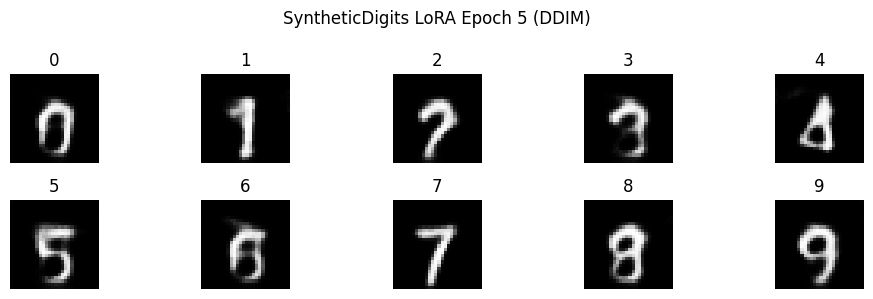

LoRA on SyntheticDigits 6/20: 100%|██████████| 79/79 [00:04<00:00, 16.39it/s, avg=0.2715, loss=0.3458]


[LoRA-SyntheticDigits] epoch 6 avg_loss=0.2715


LoRA on SyntheticDigits 7/20: 100%|██████████| 79/79 [00:05<00:00, 13.23it/s, avg=0.2759, loss=0.2439]


[LoRA-SyntheticDigits] epoch 7 avg_loss=0.2759


LoRA on SyntheticDigits 8/20: 100%|██████████| 79/79 [00:04<00:00, 16.71it/s, avg=0.2755, loss=0.2404]


[LoRA-SyntheticDigits] epoch 8 avg_loss=0.2755


LoRA on SyntheticDigits 9/20: 100%|██████████| 79/79 [00:04<00:00, 16.60it/s, avg=0.2746, loss=0.3126]


[LoRA-SyntheticDigits] epoch 9 avg_loss=0.2746


LoRA on SyntheticDigits 10/20: 100%|██████████| 79/79 [00:05<00:00, 13.79it/s, avg=0.2793, loss=0.3737]


[LoRA-SyntheticDigits] epoch 10 avg_loss=0.2793


LDM DDIM 샘플링 중: 100%|██████████| 50/50 [00:00<00:00, 139.05it/s]


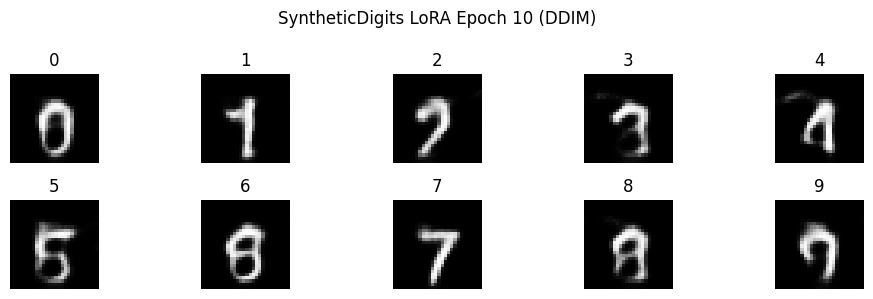

LoRA on SyntheticDigits 11/20: 100%|██████████| 79/79 [00:04<00:00, 16.87it/s, avg=0.2753, loss=0.3052]


[LoRA-SyntheticDigits] epoch 11 avg_loss=0.2753


LoRA on SyntheticDigits 12/20: 100%|██████████| 79/79 [00:05<00:00, 14.22it/s, avg=0.2691, loss=0.1733]


[LoRA-SyntheticDigits] epoch 12 avg_loss=0.2691


LoRA on SyntheticDigits 13/20: 100%|██████████| 79/79 [00:04<00:00, 17.15it/s, avg=0.2700, loss=0.3589]


[LoRA-SyntheticDigits] epoch 13 avg_loss=0.2700


LoRA on SyntheticDigits 14/20: 100%|██████████| 79/79 [00:04<00:00, 17.13it/s, avg=0.2724, loss=0.1850]


[LoRA-SyntheticDigits] epoch 14 avg_loss=0.2724


LoRA on SyntheticDigits 15/20: 100%|██████████| 79/79 [00:06<00:00, 13.15it/s, avg=0.2733, loss=0.2194]


[LoRA-SyntheticDigits] epoch 15 avg_loss=0.2733


LDM DDIM 샘플링 중: 100%|██████████| 50/50 [00:00<00:00, 143.31it/s]


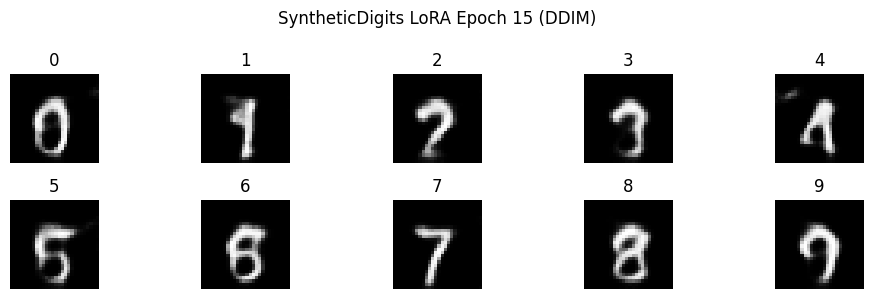

LoRA on SyntheticDigits 16/20: 100%|██████████| 79/79 [00:04<00:00, 15.84it/s, avg=0.2781, loss=0.3852]


[LoRA-SyntheticDigits] epoch 16 avg_loss=0.2781


LoRA on SyntheticDigits 17/20: 100%|██████████| 79/79 [00:05<00:00, 13.89it/s, avg=0.2670, loss=0.2363]


[LoRA-SyntheticDigits] epoch 17 avg_loss=0.2670


LoRA on SyntheticDigits 18/20: 100%|██████████| 79/79 [00:04<00:00, 16.65it/s, avg=0.2821, loss=0.3095]


[LoRA-SyntheticDigits] epoch 18 avg_loss=0.2821


LoRA on SyntheticDigits 19/20: 100%|██████████| 79/79 [00:04<00:00, 16.18it/s, avg=0.2739, loss=0.3884]


[LoRA-SyntheticDigits] epoch 19 avg_loss=0.2739


LoRA on SyntheticDigits 20/20: 100%|██████████| 79/79 [00:05<00:00, 14.09it/s, avg=0.2788, loss=0.3003]


[LoRA-SyntheticDigits] epoch 20 avg_loss=0.2788


LDM DDIM 샘플링 중: 100%|██████████| 50/50 [00:00<00:00, 134.58it/s]


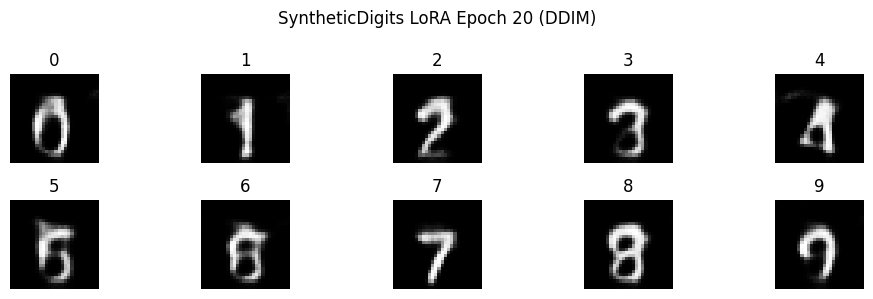

✅ LoRA fine-tuning on SyntheticDigits done. (Conv + Attention LoRA)


In [29]:
#@title 6. Synthetic Digits (인공 숫자 0~9)로 LoRA 미세학습 (Conv + Attention LoRA, textbbox fix)

from PIL import Image, ImageDraw, ImageFont
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# ==========================================================
# 1️⃣ 인공 숫자 Dataset 생성 (기계가 쓴 정자체 0~9)
# ==========================================================
# --- 교체용 SyntheticDigits 클래스 (숫자 크기 확대 버전) ---
class SyntheticDigits(Dataset):
    def __init__(self, num_samples=10000, img_size=28, transform=None):
        self.num_samples = num_samples
        self.img_size = img_size
        self.transform = transform

        # ✅ Colab에서 사용할 폰트 자동탐색 + fallback
        try:
            import os
            font_path = None
            for path in [
                "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",  # Colab 일반
                "/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf",  # 일부 런타임
                "/usr/share/fonts/truetype/freefont/FreeSansBold.ttf"
            ]:
                if os.path.exists(path):
                    font_path = path
                    break

            if font_path is None:
                raise FileNotFoundError("폰트 파일을 찾을 수 없음")

            self.font = ImageFont.truetype(font_path, 24)
        except Exception as e:
            print(f"⚠️ 폰트 로드 실패, 기본 폰트 사용: {e}")
            self.font = ImageFont.load_default()

        self.images, self.labels = self._generate()

    def _generate(self):
        imgs, labels = [], []
        for _ in range(self.num_samples):
            label = np.random.randint(0, 10)
            img = Image.new("L", (self.img_size, self.img_size), color=0)
            draw = ImageDraw.Draw(img)
            text = str(label)

            bbox = draw.textbbox((0, 0), text, font=self.font)
            w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
            pos = ((self.img_size - w) // 2, (self.img_size - h) // 2)

            draw.text(pos, text, fill=255, font=self.font)
            imgs.append(img)
            labels.append(label)
        return imgs, labels

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label




# ==========================================================
# 2️⃣ 데이터셋 구성 및 시각화
# ==========================================================
transform = transforms.Compose([
    transforms.RandomAffine(5, translate=(0.05, 0.05)),  # 살짝 흔들림
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

synthetic_train = SyntheticDigits(num_samples=10000, transform=transform)
synthetic_loader = DataLoader(synthetic_train, batch_size=128, shuffle=True, num_workers=2)

print(f"🧮 SyntheticDigits samples: {len(synthetic_train)}")

# 샘플 시각화
samples, labels = next(iter(synthetic_loader))
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(samples[i, 0].cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
    plt.axis("off")
    plt.title(str(labels[i].item()))
plt.suptitle("Synthetic Digits (정자체 0~9)")
plt.show()

# ==========================================================
# 3️⃣ U-Net에 LoRA 주입 (Conv + Attention)
# ==========================================================
print("🔧 Injecting LoRA into U-Net (Conv + Attention)...")
unet_lora = add_lora_to_unet(unet, rank=16, alpha=32.0)
ldm.unet = unet_lora.to(device)

# ==========================================================
# 4️⃣ 학습 가능한 LoRA 파라미터 확인
# ==========================================================
lora_params = [p for p in unet_lora.parameters() if p.requires_grad]
total_params = sum(p.numel() for p in ldm.unet.parameters())
lora_params_count = sum(p.numel() for p in lora_params)
ratio = 100 * lora_params_count / total_params

print(f"📊 LDM 전체 파라미터: {total_params/1e6:.2f}M")
print(f"📦 LoRA 학습 파라미터: {lora_params_count/1e6:.2f}M")
print(f"🔹 전체 대비 LoRA 비율: {ratio:.3f}%")

# ==========================================================
# 5️⃣ LoRA 미세학습
# ==========================================================
optimizer_lora = torch.optim.Adam(lora_params, lr=2e-4, betas=(0.9, 0.999))
EPOCHS_LORA = 20

for epoch in range(EPOCHS_LORA):
    ldm.unet.train()
    running = 0.0
    pbar = tqdm(synthetic_loader, desc=f"LoRA on SyntheticDigits {epoch+1}/{EPOCHS_LORA}")
    for i, (imgs, labels) in enumerate(pbar):
        imgs, labels = imgs.to(device), labels.to(device)

        loss = ldm.get_loss(imgs, labels)
        optimizer_lora.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lora_params, 1.0)
        optimizer_lora.step()

        running += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}", avg=f"{running/(i+1):.4f}")

    avg_loss = running / len(synthetic_loader)
    print(f"[LoRA-SyntheticDigits] epoch {epoch+1} avg_loss={avg_loss:.4f}")

    # === 중간 샘플 생성 ===
    if (epoch + 1) % 5 == 0:
        ldm.unet.eval()
        with torch.no_grad():
            samples = ldm.ddim_sample(batch_size=10, class_labels=torch.arange(10, device=device))
        plt.figure(figsize=(10, 3))
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(samples[i, 0].cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.title(f"{i}")
        plt.suptitle(f"SyntheticDigits LoRA Epoch {epoch+1} (DDIM)")
        plt.tight_layout()
        plt.show()

print("✅ LoRA fine-tuning on SyntheticDigits done. (Conv + Attention LoRA)")


LDM DDIM 샘플링 중: 100%|██████████| 50/50 [00:00<00:00, 137.66it/s]
/tmp/ipython-input-835007881.py:18: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-835007881.py:18: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


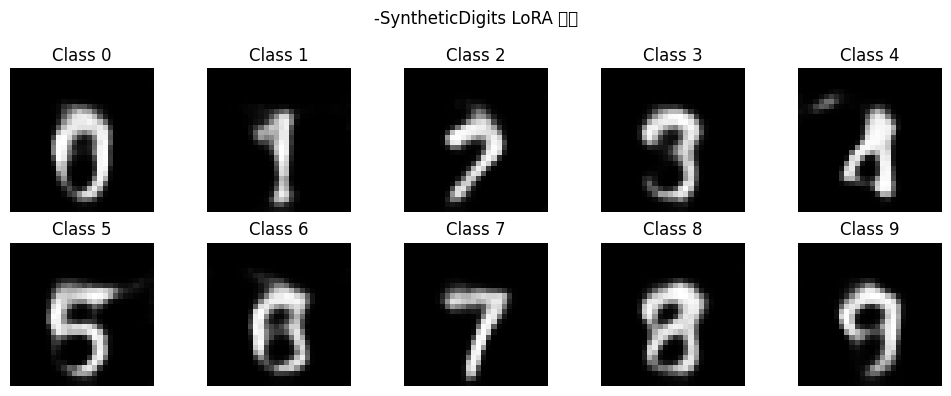

In [30]:
#@title 7. MNIST base vs LoRA-SyntheticDigits 생성 비교

# -SyntheticDigits LoRA 모델 샘플만 보기
ldm.unet.eval()

with torch.no_grad():
    # -SyntheticDigits 라벨(0~9)에 대응하는 샘플 10장
    cls = torch.tensor(list(range(10)), device=device)
    fashion_like = ldm.ddim_sample(10, class_labels=cls, ddim_timesteps=50)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    r, c = divmod(i, 5)
    axes[r, c].imshow(fashion_like[i, 0].cpu().numpy(), cmap='gray')
    axes[r, c].axis('off')
    axes[r, c].set_title(f"Class {cls[i].item()}")
plt.suptitle("-SyntheticDigits LoRA 샘플")
plt.tight_layout()
plt.show()

